<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Making imports

In [43]:
#we need Torch 1.12 + and Torchvision 0.13 + for this study
try:
  import torch, torchvision
  assert int(torch.__version__.split(".")[1])>=12, "Torch version should be 1.12 or above"
  assert int(torchvision.__version__.split(".")[1])>=13, "Torch version should be 0.12 or above"
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")
except:
  print("Available libraries not updated, downloading updated libraries")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch, torchvision
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")

Available libraries not updated, downloading updated libraries
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Torch version:2.3.0+cu121
torchvision version:0.18.0+cu121


In [44]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

Add previously written scripts

In [45]:
%%writefile data_setup.py
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

NUM_WORKERS= os.cpu_count()
def create_dataloaders(
    train_dir: str,
    test_dir:str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size:int,
    num_workers: int=NUM_WORKERS
):

  training_data=datasets.ImageFolder(root=train_dir, transform=train_transform)
  testing_data=datasets.ImageFolder(root=test_dir, transform=test_transform)
  class_names=training_data.classes
  train_dataloader=DataLoader(dataset=training_data,
                              batch_size=batch_size,#sample per dataloader
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory= True)
  test_dataloader=DataLoader(dataset=testing_data,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory= True)
  return train_dataloader, test_dataloader, class_names


Overwriting data_setup.py


In [46]:
%%writefile engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
              device: torch.device) -> Tuple[float, float]:
  #putting in training mode
  model.train()
  #setup training loss and training accuracy
  train_loss,train_acc=0,0

  for batch,(x,y) in enumerate(dataloader):
    #send data to target device
    x,y=x.to(device),y.to(device)
    #forward pass
    y_pred=model(x)
    #calculate and accumulate losses
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    #optimizer zero grad
    optimizer.zero_grad()
    #loss backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric for all batches
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #getting average loss and accuracy for each batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
  #putting in eval mode
  model.eval()
  #setup test loss and test accuracy
  test_loss,test_acc=0,0
  #turn on inference context manager
  with torch.inference_mode():
    #loop through dataloader batches
    for batch,(x,y) in enumerate(dataloader):
      #send data to target device
      x,y=x.to(device),y.to(device)
      #forward pass
      test_pred_logits=model(x)
      #calculate and accumulate loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()
      #calculate and accumulate accuracy
      test_pred_labels=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)#can probably also use len(test_pred), not sure both should work i think
  #getting average loss and accuracy for each batch
  test_acc/=len(dataloader)
  test_loss/=len(dataloader)
  return test_loss, test_acc

#defining functions and various required parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs: int,
        device: torch.device) -> Dict[str, list]:
  #create empty results dictionary
  results={"train_loss":[],
           "test_loss":[],
           "train_acc":[],
           "test_acc":[]}
  #looping through train_step() and test_step()
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss, test_acc=test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device)
  #print whats happening
    print(
        f"Epoch:{epoch+1}|"
        f"Train Loss:{train_loss:.4f}|"
        f"Training Accuracy: {train_acc:.4f}|"
        f"Test Loss: {test_loss:.4f}|"
        f"Test Accuracy: {test_acc:.4f}"
    )
    #updating result dictionary
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
  return results


Overwriting engine.py


In [47]:
%%writefile utils.py
import torch
from pathlib import Path
def save_model(model:torch.nn.Module,
               target_dir: str,
               model_name:str):
  #creating target directory
  target_dir_path=Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  #creating model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path/model_name

  #save the model state_dict
  print(f"Saving model to:{model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting utils.py


Device agnostic code

In [48]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Make function to set seeds

In [49]:
#set seeds
def set_seeds(seed:int=69):
  "set seed whenver required before torch operations. Default seed = 69"
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

Download data

In [50]:
import requests
import zipfile
from pathlib import Path
import os
def download_data(source:str,
                  destination:str,
                  remove_source:bool=True)->Path:
  #setup path to data folder
  data_path= Path("data/")
  image_path=data_path/destination
  #check if image folder exists or not, if not prepare it
  if image_path.is_dir():
    print(f"{image_path} directory exists")
  else:
    print(f"Didnt find {image_path}, creating...")
    image_path.mkdir(parents=True, exist_ok=True)
    #the datset that will be used is a formatted dataset being taken from a github file, in general, wont get such formatted data
    #download pizza, steak, sushi data in zip file
    target_file=Path(source).name
    with open(data_path/target_file,"wb") as f:
      request = requests.get(source)
      print("Downloading data...")
      f.write(request.content)
    #unzip data
    with zipfile.ZipFile(data_path/target_file,"r") as zip_ref:
      print("Unzipping food_stuff file...")
      zip_ref.extractall(image_path)
    if remove_source:
      os.remove(data_path/target_file)
  return image_path
image_path=download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination='pizza_steak_sushi')
image_path

data/pizza_steak_sushi directory exists


PosixPath('data/pizza_steak_sushi')

In [51]:
!ls data/pizza_steak_sushi

test  train


setup paths to training and testing data


In [52]:
#creating paths to train and test directories
train_dir=image_path/"train"
test_dir=image_path/"test"

Creating appropriate transforms

In [53]:
IMG_SIZE=224
manual_transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                     transforms.ToTensor()])
print(f'manually created transofrm is : {manual_transform}')

manually created transofrm is : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Create dataloaders

In [54]:
from data_setup import create_dataloaders
#setting batch size
BATCH_SIZE=32#GOOGLE COLAB FREE GPU WONT BE ABLE TO HANDLE MUCH BIGGER BATCH SIZES THAN THIS
train_dataloader,test_dataloader, class_names=create_dataloaders(train_dir=train_dir,
                                                                 test_dir=test_dir,
                                                                 train_transform=manual_transform,
                                                                 test_transform=manual_transform,
                                                                 batch_size=BATCH_SIZE)

Visualize the dataloaders and individual images

In [55]:
next(iter(train_dataloader))

[tensor([[[[0.2431, 0.2510, 0.2588,  ..., 0.0235, 0.0235, 0.0235],
           [0.2471, 0.2588, 0.2706,  ..., 0.0118, 0.0118, 0.0118],
           [0.2392, 0.2588, 0.2745,  ..., 0.0039, 0.0039, 0.0078],
           ...,
           [0.4902, 0.4941, 0.4902,  ..., 0.4706, 0.4706, 0.4745],
           [0.4784, 0.4863, 0.4902,  ..., 0.4745, 0.4706, 0.4667],
           [0.4706, 0.4745, 0.4824,  ..., 0.4667, 0.4667, 0.4745]],
 
          [[0.0941, 0.1137, 0.1373,  ..., 0.0235, 0.0235, 0.0235],
           [0.1176, 0.1373, 0.1647,  ..., 0.0118, 0.0118, 0.0118],
           [0.1373, 0.1608, 0.1882,  ..., 0.0039, 0.0039, 0.0078],
           ...,
           [0.4941, 0.5020, 0.5020,  ..., 0.3843, 0.3804, 0.3843],
           [0.4902, 0.4980, 0.5020,  ..., 0.3882, 0.3843, 0.3804],
           [0.4902, 0.4980, 0.5020,  ..., 0.3804, 0.3804, 0.3882]],
 
          [[0.0000, 0.0078, 0.0353,  ..., 0.0314, 0.0314, 0.0314],
           [0.0235, 0.0431, 0.0824,  ..., 0.0196, 0.0196, 0.0196],
           [0.0706, 0.10

In [56]:
sample_image_batch, sample_label_batch=next(iter(train_dataloader))
image, label=sample_image_batch[0], sample_label_batch[0]
image.shape,label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

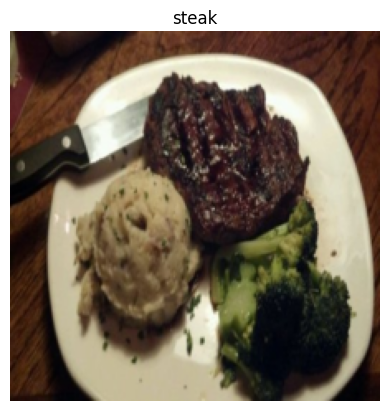

In [57]:
#plot individual image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

##Replicating the architecture from paper

Calculating patch embedding shape

In [58]:
#create sample values
height=224
width=224
patch_size=16
color_channel=3
number_of_patches= int(height*width/patch_size**2)
print(f"for image of dimensions{color_channel}x{height}x{width}(CxHxW), embedding with patch size {patch_size} has dimensions {number_of_patches}x{patch_size**2 * color_channel}(NxP^2*C)")

for image of dimensions3x224x224(CxHxW), embedding with patch size 16 has dimensions 196x768(NxP^2*C)


In [59]:
embedding_layer_input_shape=(color_channel,height,width)
embedding_layer_output_shape=(number_of_patches, patch_size**2 * color_channel)
print("embedding_layer_input_shape=",embedding_layer_input_shape)
print("embedding_layer_output_shape=",embedding_layer_output_shape)

embedding_layer_input_shape= (3, 224, 224)
embedding_layer_output_shape= (196, 768)


Visualize single image

(-0.5, 223.5, 223.5, -0.5)

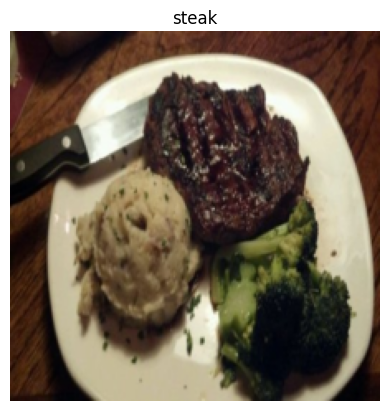

In [60]:
#plot after changing dimension accoriding to matplotlib
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

(-0.5, 223.5, 15.5, -0.5)

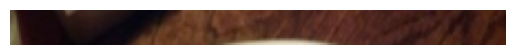

In [61]:
#visualizing taking just patches of the topmost layer
image_permuted=image.permute(1,2,0)
plt.imshow(image_permuted[:patch_size,:,:])
plt.axis(False)

Creating series of subplots for top layer of image

number of patches in 1 row=14


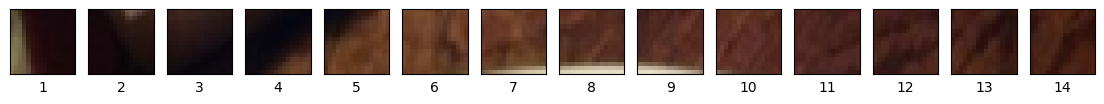

In [62]:
image_size=224
patch_size=16
num_patches=int(image_size/patch_size)
assert image_size%patch_size== 0, "image size is not divisible by patch size"
print(f"number of patches in 1 row={num_patches}")
#making series of plots
fig,axs=plt.subplots(nrows=1,
                     ncols=num_patches,
                     figsize=(num_patches, num_patches),# WHY IS FIGSIZE NUM_PATCHES
                     sharex=True,
                     sharey=True)
#iterating through patches in top row
for i,patch in enumerate(range(0,image_size, patch_size)): #enumerate is only used because also needed index i
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Creating series of subplots for whole image

number of patches in 1 row:14
 number of patches in 1 column:14
 total nnumber of patches: 196
 patch size:16x16


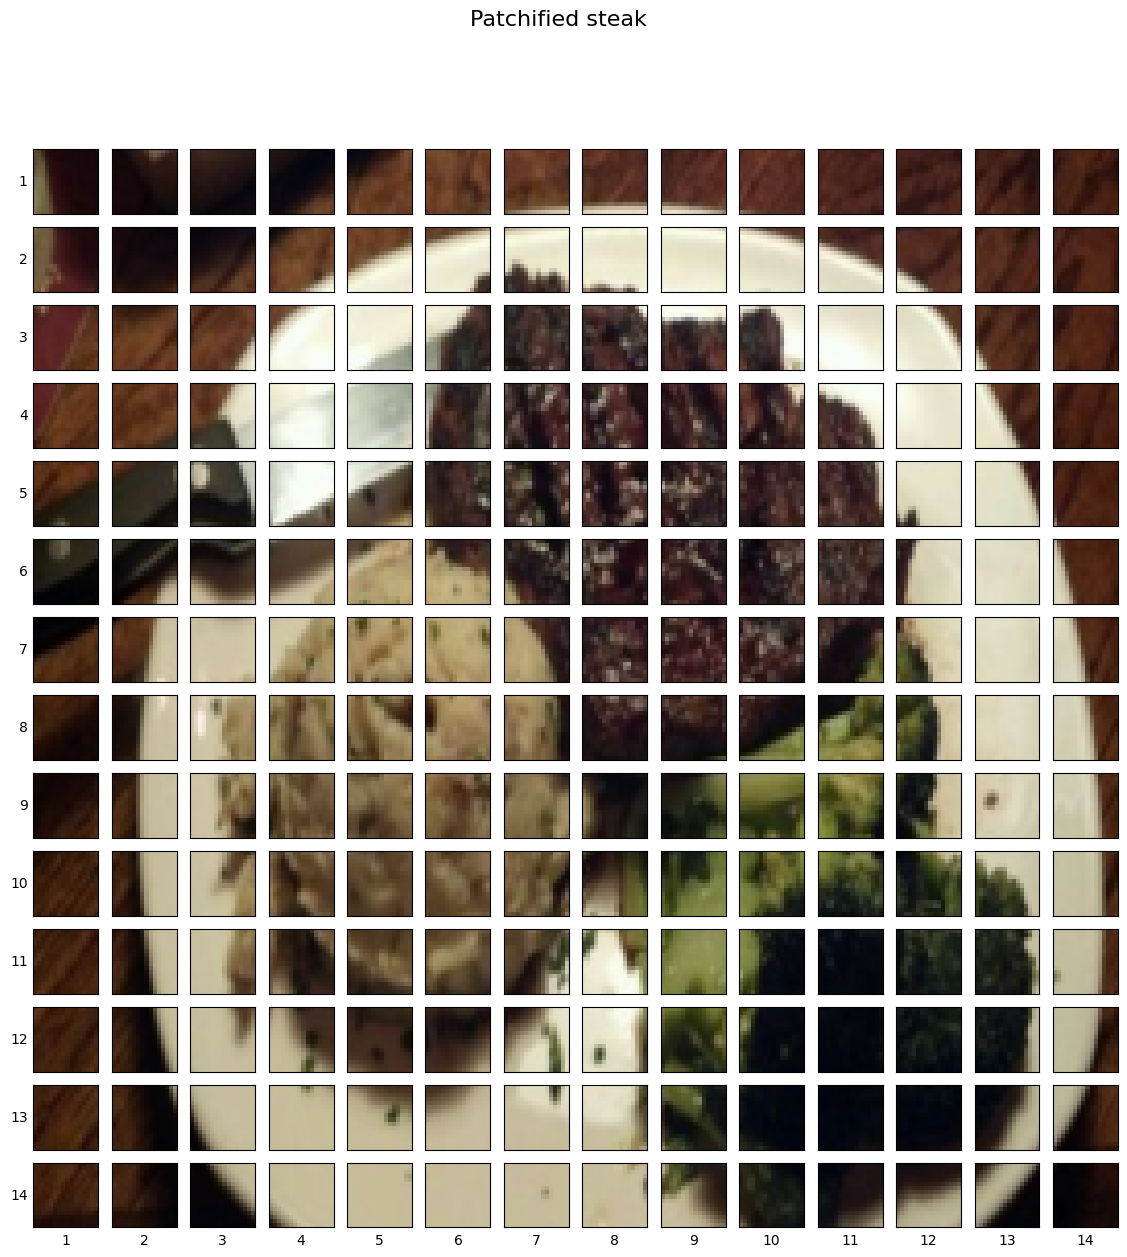

In [66]:
image_size=224
patch_size=16
num_patches=int(image_size/patch_size)
assert image_size%patch_size== 0, "image size is not divisible by patch size"
print(f"number of patches in 1 row:{num_patches}\n number of patches in 1 column:{num_patches}\n total nnumber of patches: {num_patches**2}\n patch size:{patch_size}x{patch_size}")
#making series of subplots
fig,axs=plt.subplots(nrows=num_patches,
                     ncols=num_patches,
                     figsize=(num_patches, num_patches),# WHY IS FIGSIZE NUM_PATCHES
                     sharex=True,
                     sharey=True)

#iterating through all patches
for i, patch_height in enumerate(range(0, image_size, patch_size)):
  for j,patch_width in enumerate(range(0,image_size, patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,#for selecting the row of patches
                                   patch_width:patch_width+patch_size,#for selecting the column of patches
                                   :])#for all color channels
    axs[i,j].set_ylabel(i+1,
                        rotation='horizontal',
                        horizontalalignment='right',
                        verticalalignment='center')
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

fig.suptitle(f"Patchified {class_names[label]}", fontsize=16)
plt.show()

Making patches using CNN layers rather than manually

In [67]:
from torch import nn
#making CNN layer to convert a patch into D- dimensional vector which will be the patch embedding
patch_size=16

conv2d=nn.Conv2d(in_channels=3,#number of color channels
                 out_channels=786,#from table 1 in paper, the base model has hidden size D=786
                 stride=patch_size,
                 kernel_size=patch_size,
                 padding=0)


In [72]:
#passing through single image to see what happens
print(image.shape)
image_through_CNN=conv2d(image)
print(image_through_CNN.shape)
image_with_batchsize_through_CNN=conv2d(image.unsqueeze(0))
print(image_with_batchsize_through_CNN.shape)

torch.Size([3, 224, 224])
torch.Size([786, 14, 14])
torch.Size([1, 786, 14, 14])
